# Model Definition and Evaluation
## Table of Contents
1. [Model Selection](#model-selection)
2. [Feature Engineering](#feature-engineering)
3. [Hyperparameter Tuning](#hyperparameter-tuning)
4. [Implementation](#implementation)
5. [Evaluation Metrics](#evaluation-metrics)
6. [Comparative Analysis](#comparative-analysis)


In [1]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 kB 2.5 MB/s eta 0:00:00


In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, mean_squared_error, classification_report, mean_absolute_error
import matplotlib.pyplot as plt
# Import models you're considering
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner as kt
from sklearn.preprocessing import MinMaxScaler
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential


from sklearn.model_selection import GridSearchCV


/var/folders/g3/9v4gs6r57_7_bc8nsrqdz_t40000gn/T/ipykernel_56637/480258712.py:12: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


## Model Selection


We consider a neural network or an LSTM (those were used in the models in the literature review)



## Feature Engineering

Three feature engeneering steps were performed: Instead of using the max und min temperature, the span of temperature of that day was used. --> Tells if the weather was stable or fluctuating that day

The interaction between the average Temperature and the humidity is used -->There is a correlation between these two parameters


The pressure change is also interesting, a decreasing pressure indicates a low pressure area, an increasing pressure indicates a high pressure area


In [2]:
df = pd.read_csv(
    '../Dobersdorf/Dobersdorf_all_cut_final.csv',
    nrows=5
)

print(df)

   Tag  Monat  Jahr Produktion(kWH)         Tavg  Tmin  Tmax          Hum  \
0   16      7  2023           55,79  18,22083333  15,8  22,1  74,91666667   
1   17      7  2023           54,63  16,38333333  12,4  19,4        78,75   
2   18      7  2023           65,68  16,70416667  11,8  21,6  73,54166667   
3   19      7  2023           28,26      14,7125  12,7  17,2       85,625   
4   20      7  2023           58,93  14,91666667  10,7  19,4         76,5   

           VPD Prec  Pbin         Wspd Wmax         Wdir          Cld   Sol  \
0   0,56164731  0,8     1  4,445833333    7  219,5186547        6,125  1991   
1  0,424523113    7     1  3,929166667    6  236,8576391  6,041666667  2102   
2  0,577180231    0     1  2,941666667  5,3    253,92248  5,416666667  2578   
3  0,247361166  2,9     1  1,820833333  2,9  244,7083359  7,291666667  1121   
4  0,447117605  0,3     1        3,625  6,1  268,2167486  3,708333333  2456   

    Sun         Pres          Vis  Soil  
0   7,7  1004,179167

In [2]:
# Load the dataset
# Replace 'your_dataset.csv' with the path to your actual dataset
df = pd.read_csv('../Elmshorn/Elmshorn_all_cut_extend.csv', sep=";", decimal=",", header=0)
print(df.columns.tolist())
print(df.dtypes)

####the floats are not recognized as floats
for col in df.columns:
    if df[col].dtype == object:
        df[col] = (
            df[col].str.replace(',', '.', regex=False).pipe(pd.to_numeric, errors='ignore')
        )
print(df.dtypes)
# Perform any feature engineering steps
# Example: df['new_feature'] = df['feature1'] + df['feature2']
df['temp_range'] = df['Tmax'] - df['Tmin']
df['temp_hum_interaction'] = df['Tavg'] * df['Hum']
##.diff() calculates the difference to the value the day before
df['pressure_change'] = df['Pres'].diff()

# Feature and target variable selection
X = df[['Tavg', 'temp_range','temp_hum_interaction','Sun','Pres','pressure_change','Vis', 'Tmin']]
y = df['Power Generation [kWh]']
###values between 0 and 1
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
y = np.array(y).reshape(-1, 1)
y_scaled = scaler.fit_transform(y)

print (int(len(df))*0.7)
print (int(len(df))*0.15)
print (int(len(df)))


split_index = int(len(df) * 0.8)
X_train, X_test = X_scaled[:split_index], X_scaled[split_index:]
y_train, y_test = y_scaled[:split_index], y_scaled[split_index:]

# Split the dataset
##Splitting time series data random is problematic
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(len(X_train))
print(len(X_test))
print(len(y_train))
print(len(y_test))
print(X_train)
print(y_train)

###here we had to exclude missing values
X_train = np.nan_to_num(X_train, nan=0.0, posinf=0.0, neginf=0.0)

print("X nan:", np.isnan(X_train).any())
print("y nan:", np.isnan(y_train).any())
print("X inf:", np.isinf(X_train).any())
print("y inf:", np.isinf(y_train).any())

###here we had to exclude missing values
X_test= np.nan_to_num(X_test, nan=0.0, posinf=0.0, neginf=0.0)

print("X nan:", np.isnan(X_train).any())
print("y nan:", np.isnan(y_train).any())
print("X inf:", np.isinf(X_train).any())
print("y inf:", np.isinf(y_train).any())

['Date: Day.Month.Year', 'Power Generation [kWh]', 'Tavg', 'Tmin', 'Tmax', 'Hum', 'VPD', 'Prec', 'Pbin', 'Wspd', 'Wmax', 'Wdir', 'Cld', 'Sol', 'Sun', 'Pres', 'Vis', 'Soil', 'Unnamed: 18', 'Unnamed: 19', 'Unnamed: 20', 'Unnamed: 21', 'Unnamed: 22', 'Unnamed: 23', 'Unnamed: 24', 'Unnamed: 25', 'Unnamed: 26', 'Unnamed: 27', 'Unnamed: 28', 'Unnamed: 29', 'Unnamed: 30', 'Unnamed: 31', 'Unnamed: 32', 'Unnamed: 33']
Date: Day.Month.Year       object
Power Generation [kWh]    float64
Tavg                      float64
Tmin                      float64
Tmax                      float64
Hum                       float64
VPD                       float64
Prec                      float64
Pbin                      float64
Wspd                      float64
Wmax                      float64
Wdir                      float64
Cld                       float64
Sol                       float64
Sun                       float64
Pres                      float64
Vis                       float64
Soil     

/var/folders/g3/9v4gs6r57_7_bc8nsrqdz_t40000gn/T/ipykernel_56637/178482068.py:11: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[col].str.replace(',', '.', regex=False).pipe(pd.to_numeric, errors='ignore')


## Hyperparameter Tuning

[Discuss any hyperparameter tuning methods you've applied, such as Grid Search or Random Search, and the rationale behind them.]


In [ ]:
!pip install scikeras
!pip install -U scikit-learn scikeras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 72.9 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1


In [3]:
def dimension_train(X, y, time_step=1):
      X1, y1 = [], []
      X = np.array(X)
      y = np.array(y)
      for i in range(len(X) - time_step):
        X1.append(X[i:i+time_step,:])
        y1.append(y[i+time_step])
      return np.array(X1), np.array(y1)

time_step = 10
X,y=dimension_train(X_train,y_train, time_step)

print(len(X))
print(len(y))


655
655


In [99]:
# Implement hyperparameter tuning
# Example using GridSearchCV with a DecisionTreeClassifier
# param_grid = {'max_depth': [2, 4, 6, 8]}
# grid_search = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5)
# grid_search.fit(X_train, y_train)
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import GridSearchCV
time_step = 10
def model1(units=40,learning_rate=0.1):
  model1 = Sequential()
  model1.add(Input(shape=(time_step, 8)))
  model1.add(LSTM(units, return_sequences=True))
  model1.add(LSTM(units))
  model1.add(Dense(1))
  model1.compile(optimizer = keras.optimizers.Adam( learning_rate=learning_rate), loss='mean_squared_error')
  return model1

model = KerasRegressor(
    model=model1,
    verbose=0
)


###I wanted to test more parameters, but it took so long and the runtime disconnected without finishing###
param_grid = {
    "model__units": [50, 60],
    "batch_size": [8, 16],
    "epochs": [50, 60],
    "model__learning_rate": [0.0001,0.00001]

}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5)
grid_search.fit(X, y)



,estimator,KerasRegresso...se epochs=1 )
,param_grid,"{'batch_size': [8, 16], 'epochs': [50, 60], 'model__learning_rate': [0.0001, 1e-05], 'model__units': [50, 60]}"
,scoring,None
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,model,<function mod...t 0x319488b80>


In [100]:
print(grid_search.best_params_)

{'batch_size': 8, 'epochs': 50, 'model__learning_rate': 0.0001, 'model__units': 60}


## Implementation

[Implement the final model(s) you've selected based on the above steps.]


In [ ]:


# Build the LSTM model(with hyperparameters)
model = Sequential()
model.add(LSTM(60, return_sequences=True, input_shape=(time_step, 8)))
model.add(LSTM(60))
model.add(Dense(1))
model.compile(optimizer= keras.optimizers.Adam(learning_rate=0.0001), loss='mean_squared_error')

# Train the model
result=model.fit(X, y, epochs=50, batch_size=16,validation_split=0.15)




Epoch 1/50


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0921 - val_loss: 0.1173
Epoch 2/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0531 - val_loss: 0.1037
Epoch 3/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0456 - val_loss: 0.0832
Epoch 4/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0428 - val_loss: 0.0857
Epoch 5/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0429 - val_loss: 0.0823
Epoch 6/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0416 - val_loss: 0.0789
Epoch 7/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0411 - val_loss: 0.0895
Epoch 8/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0406 - val_loss: 0.0782
Epoch 9/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0405 - val_loss: 0.0784
Epoch 10/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0401 - val_loss: 0.0819
Epoch 11/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0398 - val_loss: 0.0749
Epoch 12/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0402 - val_loss: 0.0786


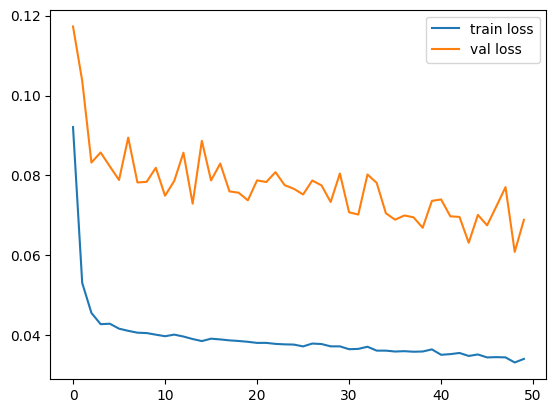

In [102]:
plt.plot(result.history["loss"], label="train loss")
plt.plot(result.history["val_loss"], label="val loss")
plt.savefig('Dobersdorf_LSTM_loss.png', dpi=300)
plt.legend()
plt.show()

In [103]:
print(len(X_test))
print(len(y_test))
###For the test sets
def dimension_test(X, y, time_step=1):
      X2, y2 = [], []
      X = np.array(X)
      y = np.array(y)
      for i in range(len(X) - time_step):
        X2.append(X[i:i+time_step,:])
        y2.append(y[i + time_step - 1])
      return np.array(X2), np.array(y2)

time_step = 10
X_test1,y_test1=dimension_test(X_test,y_test, time_step)
print(len(X_test1))
print(len(y_test1))


167
167
157
157


## Evaluation Metrics

[Clearly specify which metrics you'll use to evaluate the model performance, and why you've chosen these metrics.]


In [104]:
# Evaluate the model using your chosen metrics
# Example for classification
# y_pred = model.predict(X_test)
# print(classification_report(y_test, y_pred))
y_pred = model.predict(X_test1)
mse = mean_squared_error(y_test1, y_pred)
print("Mean squared error is:",mse)
mae= mean_absolute_error(y_test1, y_pred)
print("Mean absolute error is:",mae)

final=mae/np.max(y_test1)*100
print(final)



5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Mean squared error is: 0.026808271447101066
Mean absolute error is: 0.1338641288744468
14.63747951243951


## Comparative Analysis

[Compare the performance of your model(s) against the baseline model. Discuss any improvements or setbacks and the reasons behind them.]


In [105]:
# Comparative Analysis code (if applicable)
# Example: comparing accuracy of the baseline model and the new model
##Comparing the Mse
##replace with new value
baseline_mse= 0.01206
print(f"Baseline Model mse: {baseline_mse}, New Model Accuracy: {mse:.4}")
print(f"The percentage error is: {final:.4} %")


Baseline Model mse: 0.01206, New Model Accuracy: 0.02681
The percentage error is: 14.64 %


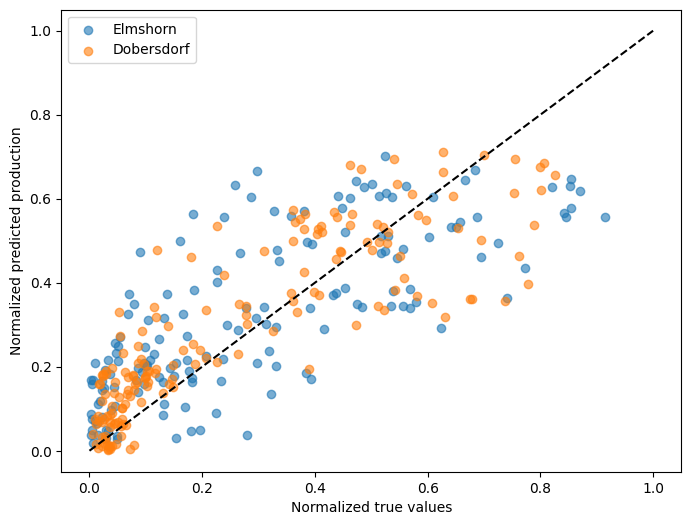

In [106]:
#DB=np.load('Elmshorn_baseline_true_vs_predicted.npy')
DB=np.load('Dobersdorf_LSTM_true_vs_predicted_lr0.0001.npy')

##elmshorn
plt.figure(figsize=(8,6))
#plt.scatter(y_test1, y_pred)
#plt.scatter(y_test1, y_pred, label='LSTM Model', alpha=0.6)
#plt.scatter(DB[0], DB[1], label='Baseline Model', alpha=0.6)
plt.scatter(y_test1, y_pred, label='Elmshorn', alpha=0.6)
plt.scatter(DB[0], DB[1], label='Dobersdorf', alpha=0.6)
plt.plot([0,1],[0,1], 'k--')
plt.xlabel('Normalized true values')
plt.ylabel('Normalized predicted production')
plt.legend()
#np.save('Elmshorn_LSTM_true_vs_predicted_lr0.0001.npy', np.array([y_test1, y_pred]))
#plt.savefig('Elmshorn_LSTM_true_vs_predicted_only.png', dpi=300, bbox_inches='tight')
#plt.savefig('Elmshorn_LSTM_vs_baseline_true_vs_predicted.png', dpi=300, bbox_inches='tight')
#plt.savefig('LSTM_vs_LSTM_true_vs_predicted.png', dpi=300, bbox_inches='tight')
plt.show()